<a href="https://www.kaggle.com/code/fahmirk/web-scraping-e-ipo-data-with-selenium?scriptVersionId=163059505" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

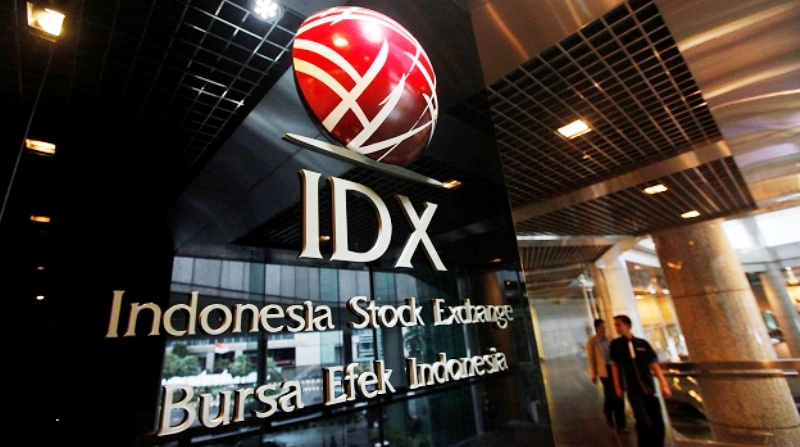<br>
<cite>Image from [m.cobisnis.com](https://m.cobisnis.com/tahun-2023-bei-targetkan-ipo-57-perusahaan)<cite>

**This notebook will explain how Chrome Driver and Selenium in Python can scrape data available on the e-IPO (Electronic Indonesia Public Offering) website in Realtime.**

### First, please **Upvote** this notebook if u like it :)

The notebook can be used to scrape all the company data available on the e-IPO website in real time, as long as the structure of the website is not changed (only the data of the company that is going to IPO is added).

**Notes**: If there is a change in the website structure, I may revise this notebook so that it can work properly.

**Disclaimer**: There may be any mistakes in this notebook because I'm not an expert, but I'm glad it works. Some of the sources I used in making this notebook are Kaggle and Stack Overflow. I am very happy if you make this as a reference. Please criticize and suggest.

**Update**:<br>
**5 August 2023**: The first **3 days return data** has been included in the dataset.<br>
**15 August 2023**: Dataset of **Listing Boards (Papan Pencatatan)** at the time of IPO available for each company code.<br>
**25 October 2023**: Return from Listing Date Data has been included in the dataset.<br>
**8 January 2024**: Listing board data is no longer retrieved manually from google spreadsheets using gdown, but uses direct access to the IDX website via selenium with proxy and undetected chromedriver. The web scraping process has been displayed in the form of a progress bar using the tqdm package.<br>
**10 January 2024**: Return data extended to the first 7 days return from 3 days return.<br>
**28 January 2024**: In addition to being exported into CSV, the dataset is also stored in google spreadsheet.

# Prerequisite

In [1]:
#Update
!apt-get update -y

#Installing the libraries used in this notebook
!apt-get install -y \
libglib2.0-0 \
libnss3 \
libdbus-glib-1-2 \
libgconf-2-4 \
libfontconfig1 \
gconf2-common \
libwayland-server0 \
libgbm1 \
udev \
libu2f-udev \
libjsoncpp25 \
libxnvctrl0

#Fix any broken dependencies that might occur during the installation process
!sudo apt --fix-broken install -y

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:7 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [601 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3413 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3853 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1473 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [32.4 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [3263 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd

In [2]:
#Install google chrome
!wget -nc -P /usr/lib https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i /usr/lib/google-chrome-stable_current_amd64.deb

import subprocess
chrome_version = subprocess.check_output(["dpkg-query", "--show", "--showformat='${Version}'", "google-chrome-stable"]).decode("utf-8").strip("''").split("-")[0]
chrome_version

--2024-02-16 09:14:12--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 172.253.123.93, 172.253.123.190, 172.253.123.136, ...
Connecting to dl.google.com (dl.google.com)|172.253.123.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106428268 (101M) [application/x-debian-package]
Saving to: '/usr/lib/google-chrome-stable_current_amd64.deb'

google-chrome-stabl 100%[===================>] 101.50M   381MB/s    in 0.3s    

2024-02-16 09:14:12 (381 MB/s) - '/usr/lib/google-chrome-stable_current_amd64.deb' saved [106428268/106428268]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack .../google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (121.0.6167.184-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libgbm

'121.0.6167.184'

In [3]:
#Install chromedriver (Chrome driver version was manually inserted == 120.0.6099.109)
!wget -nc -P /usr/lib "https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/121.0.6167.85/linux64/chromedriver-linux64.zip"
    
#Create new directory named "Chrome-browser"
!mkdir /usr/lib/chrome-browser

#Unzip chromedriver_linux64.zip and extracts its contents to "/usr/lib/chrome-browser/" directory
!unzip -o /usr/lib/chromedriver-linux64.zip -d /usr/lib/chrome-browser/

#Fix any broken dependencies that might occur during the installation process
!sudo apt --fix-broken install -y

--2024-02-16 09:14:22--  https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/121.0.6167.85/linux64/chromedriver-linux64.zip
Resolving edgedl.me.gvt1.com (edgedl.me.gvt1.com)... 34.104.35.123, 2600:1900:4110:86f::
Connecting to edgedl.me.gvt1.com (edgedl.me.gvt1.com)|34.104.35.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8643026 (8.2M) [application/octet-stream]
Saving to: '/usr/lib/chromedriver-linux64.zip'

chromedriver-linux6 100%[===================>]   8.24M  --.-KB/s    in 0.1s    

2024-02-16 09:14:22 (62.8 MB/s) - '/usr/lib/chromedriver-linux64.zip' saved [8643026/8643026]

Archive:  /usr/lib/chromedriver-linux64.zip
  inflating: /usr/lib/chrome-browser/chromedriver-linux64/LICENSE.chromedriver  
  inflating: /usr/lib/chrome-browser/chromedriver-linux64/chromedriver  



Correcting dependencies... Done
The following additional packages will be installed:
  libgbm1 libu2f-udev libudev1 libwayland-server0 udev
The following NEW packages wil

In [4]:
#Install undetected chromedriver
!pip3 install undetected-chromedriver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.2/460.2 kB 20.6 MB/s eta 0:00:00
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.4-py3-none-any.whl size=47055 sha256=db92ff412b105b15bfa7d6e6f1224ece26b42d2903aee0c11678e2aacce468a6
  Stored in directory: /root/.cache/pip/wheels/0c/a6/72/5c948853baf75d52f1da173bd8fc9d7ad7615608e0ffaead6d
Successfully built undetected-chromedriver


In [5]:
#Install Packages
!pip3 install selenium\
selenium-wire\
selenium_authenticated_proxy\
selenium_stealth\
gspread\
gspread_dataframe\
yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 4.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291653 sha256=096336fd998ee2070fd8e2a930f38de2f6f6e554de5f324afd5e7d03f06651f3
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


# Preparation

First, import all libraries used in this notebook

In [6]:
from seleniumwire import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ChromeOptions
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from selenium_stealth import stealth
from selenium_authenticated_proxy import SeleniumAuthenticatedProxy
from selenium.webdriver.support.ui import Select
import random
import undetected_chromedriver as uc
import re
import pandas as pd
from PIL import Image
import sys
import numpy as np
import time
from io import BytesIO
import yfinance as yf
import datetime
import os
import requests
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from oauth2client.service_account import ServiceAccountCredentials
import json
import gspread
from gspread_dataframe import set_with_dataframe
sys.path.insert(0,'/usr/lib/chrome-browser/chromedriver')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

Here I created some functions that are used in this notebook to make work easier. In the *update_database* function, I use *Try* and *Except* statements to handle errors that occur. If an error occurs, then no value is created in the data.

In [7]:
#Function
def Status_IPO(datalist):
    classification = ["Pre-Effective",
               "Book Building",
               "Offering",
               "Allotment",
               "Closed",
               "Canceled"]
    classification = classification[::-1]
    status = [item for item in classification if item in datalist]
    if len(set(status)) == 1:
        return(status[0])
    else:
        status.remove("Book Building")
        return(status[0])
    
def is_string_unique(string, lst):
    if lst.count(string) == 1:
        return True
    else:
        return False

def convert_to_integer(df, columns):
    for column in columns:
        df[column] = df[column].str.replace(',', '', regex=True).where(df[column].notnull(), np.nan)
        df[column] = df[column].str.replace('IDR ', '').astype('Int64').where(df[column].notnull(), np.nan)
    return df

def warrant_per_share_ratio(warantdata):
    if warantdata is None:
        return 0
    elif ':' in warantdata:
        warantdata = warantdata.split(':')
        return (float(warantdata[1]) / float(warantdata[0]))
    else:
        return warantdata
    
def update_database(data):
    #Retrieve data from the company page that will conduct an IPO
    newvalue = [
        None,  # IPO Status
        None,  # Ticker Code
        None,  # Company Name
        None,  # Sector
        None,  # Subsector
        None,  # Line of Business
        None,  # Address
        None,  # Website
        None,  # Number of Shares offered
        None,  # % of Total Shares
        None,  # Participant Admin
        None,  # Underwriter(s)
        None,  # Book Building Period
        None,  # Book Building Price
        None,  # Offering Period
        None,  # Final Price
        None,  # Allotment Date
        None,  # Distribution Date
        None,  # Listing Date
        None,  # Warrant
        None   # Exercise Price (Warrant)
    ]

    try:
        newvalue[0] = Status_IPO(data) # IPO Status
    except:
        pass

    try:
        newvalue[1] = data[2] # Ticker Code
    except:
        pass

    try:
        newvalue[2] = data[0] # Company Name
    except:
        pass

    try:
        newvalue[3] = data[data.index("Sector") + 1] # Sector
    except:
        pass

    try:
        newvalue[4] = data[data.index("Subsector") + 1] # Subsector
    except:
        pass

    try:
        newvalue[5] = data[data.index("Line Of Business") + 1] # Line Of Business
    except:
        pass

    try:
        newvalue[6] = data[data.index("Address") + 1] # Address
    except:
        pass

    try:
        if "http" in data[data.index("Website") + 1]:
            newvalue[7] = data[data.index("Website") + 1] # Website
    except:
        pass

    try:
        newvalue[8] = int(re.sub(r'[^\d]', '', data[data.index("Number of shares offered") + 1])) #Number of Shares Offered
    except:
        pass

    try:
        newvalue[9] = float(data[data.index("% of Total Shares") + 1]) # % of Total Shares
    except:
        pass

    try:
        newvalue[10] = data[data.index("Participant Admin") + 1] # Participant Admin
    except:
        pass

    try:
        newvalue[11] = data[data.index("Underwriter(s)")+1:data.index(Status_IPO(data))] # Underwriter(s)
    except:
        pass

    try:
        if is_string_unique("Book Building",data): # Book Building Period
            newvalue[12] = data[data.index("Book Building") + 1]
        else:
            newvalue[12] = data[data.index("Book Building",data.index("Book Building") + 1) + 1]
    except:
        pass

    try:
        if is_string_unique("Book Building",data): # Book Building Price
            if "IDR" in data[data.index("Book Building") + 2]:
                newvalue[13] = data[data.index("Book Building") + 2]
        else:
            if "IDR" in data[data.index("Book Building",data.index("Book Building") + 1) + 2]:
                newvalue[13] = data[data.index("Book Building",data.index("Book Building") + 1) + 2]
    except:
        pass

    try:
        if is_string_unique("Offering",data): # Offering Period
            if "-" in data[data.index("Offering") + 1]:
                newvalue[14] = data[data.index("Offering") + 1]
        else:
            if "-" in data[data.index("Offering") + 8]:
                newvalue[14] = data[data.index("Offering") + 8]
    except:
        pass

    try:
        if is_string_unique("Offering",data): # Final Price
            if "IDR" in data[data.index("Offering") + 2]:
                newvalue[15] = data[data.index("Offering") + 2]
        else:
            if "IDR" in data[data.index("Offering") + 9]:
                newvalue[15] = data[data.index("Offering") + 9]
    except:
        pass
    try:
        newvalue[16] = data[data.index("Allotment (Closing)") + 1] # Allotment Date
    except:
        pass

    try:
        newvalue[17] = data[data.index("Distribution") + 1] # Distribution Date
    except:
        pass

    try:
        newvalue[18] = data[data.index("Listing Date") + 1] # Listing Date
    except:
        pass
    
    try:
        if ":" in data[data.index("Warant") + 1]:
            newvalue[19] = data[data.index("Warant") + 1] # Warrant
    except:
        pass
    
    try:
        if "IDR" in data[data.index("Exercise Price") + 1]:
            newvalue[20] = data[data.index("Exercise Price") + 1] # Exercise Price (Warrant)
    except:
        pass
    
    #Update Data
    for key, new_value in zip(database.keys(), newvalue):
        database[key].append(new_value)

# Scraping Data Website e-IPO

After importing the libraries and declaring some functions, we can start extracting information from the e-IPO website. (https://www.e-ipo.co.id/en/ipo/index).<br>First, we need to create a connection with ChromeDriver

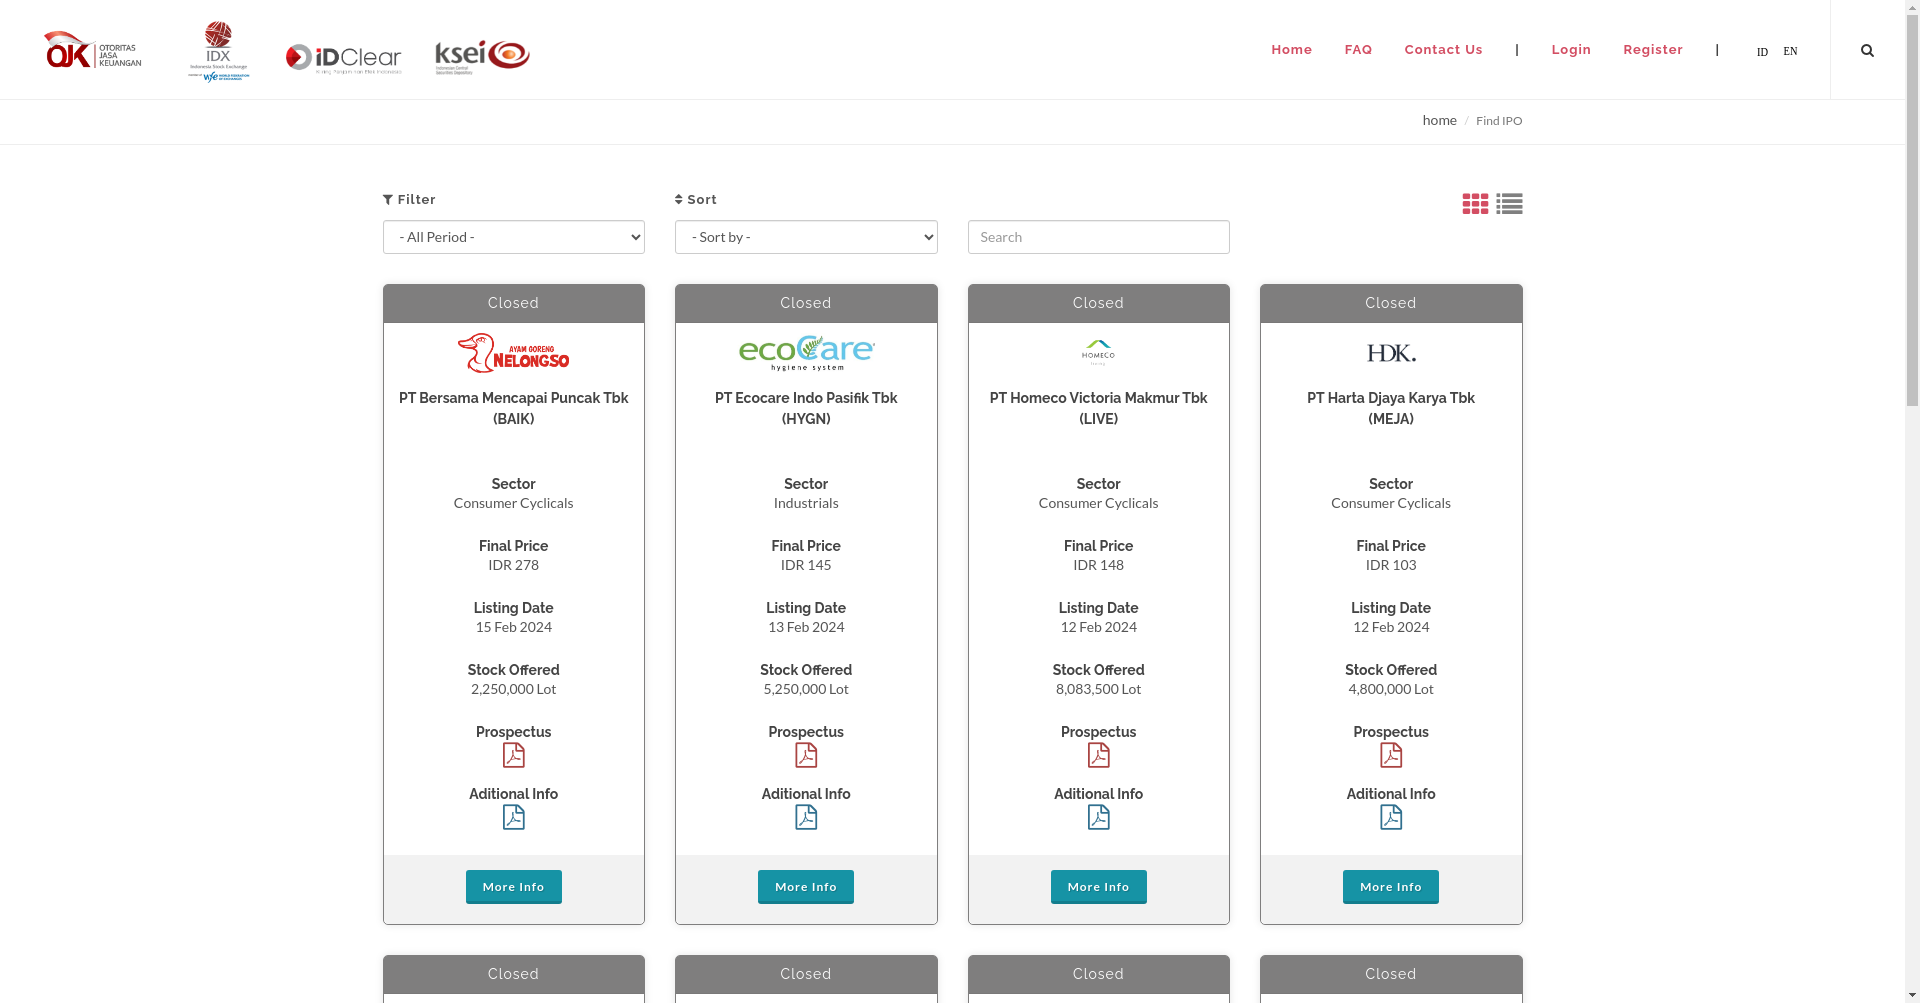

In [8]:
proxies = requests.get(UserSecretsClient().get_secret("Proxy_List_Link_4").replace('"',""))

proxies_text = proxies.text
proxies_list = [proxy.split(':') for proxy in proxies_text.split('\r\n') if proxy]
        
selected_proxy = random.choice(proxies_list)
proxy_url = f"http://{selected_proxy[2]}:{selected_proxy[3]}@{selected_proxy[0]}:{selected_proxy[1]}"
        
#Create Connection
options = uc.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')                             
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36')
options.add_argument("--window-size=1920,1080")

proxy_helper = SeleniumAuthenticatedProxy(proxy_url)
proxy_helper.enrich_chrome_options(options)

driver = uc.Chrome(use_subprocess=True,options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

url = "https://www.e-ipo.co.id/en/ipo/index"
driver.get(url)

time.sleep(3) #Wait 3 seconds for the website to display perfectly so we can get a screenshot in the next code

#This code will used next code
last_page = int(re.search(r'\bpage=(\d+)\b',
                  driver.find_element(By.XPATH,'//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a').get_attribute('href')).group(1))
    
#Take a screenshot of the website and display it.
Image.open(BytesIO(driver.get_screenshot_as_png()))

In [9]:
driver.quit()

# Breakdown Scraping Code (Scroll down to see this code)

Here, I will search for company list elements on the e-ipo website using **XPATH**. I will give an example of how to use XPATH to search for elements.<br>See this code?

    try:
        WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1]')))
        
    except TimeoutException:
        print("Timed out waiting for Response")
        break
        
In short, this code waits for a specific element specified by the XPath expression to be present on the page. This XPath expression refers to the **company list** element found on each page of the e-IPO website. If the element is found within the given timeout, the code will **continue execution**. If the element is not found, a **timeout exception will be raised**, and the code will print a message before exiting the loop.

To get the XPath code from the list company element, we can use the **Inspect Element** feature in Chrome. The following is an illustration of how I get XPath from the list company element on the e-IPO website, which is

    "//*[@id="w0"]/div[1]".

![](https://imgur.com/H0GhLga.gif)

Once the page is successfully accessed, we can retrieve the information contained in each company on the page. First, we need the link of each company. Where can we get them from? From the *More Info* element of each company. To get the link we will use XPath again. With the same steps, we get the XPath from the *More Info* element, which is

    '//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a'

![](https://imgur.com/KScrdem.gif)

After getting the XPath of the *More Info* element, we need to retrieve the link from the *href attribute* on the element with the following code

    driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a').get_attribute('href')

If you look at the XPath of other companies on the same page, you can see patterns in the XPath. The pattern looks like this

    '//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a'
    '//*[@id="w0"]/div[1]/div[2]/div/div/div[5]/a'
    '//*[@id="w0"]/div[1]/div[3]/div/div/div[5]/a'
    ...
    '//*[@id="w0"]/div[1]/div[12]/div/div/div[5]/a'

With this pattern, we can loop to get the information of all companies on each page. It is known that on each page there are 12 companies, so on each page we will iterate to retrieve company information **12 times**, shown with the following code:
    
    for j in range(12):
    
        try:
            link = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j+1)+']/div/div/div[5]/a').get_attribute('href')
            
        except NoSuchElementException:
            print('Page ' + str(i) + ': Success. There is no more information')
            break

On the last page, it is possible that the list of companies is **less than or equal to 12**, so I use a break statement with the message above indicating that **no information can be retrieved from the website** because the process has reached the last page and the last company.

After we get the company link, we can access and retrieve the information on the company page. Next we will see the following code

        driver.get(link)
        
        script = """
            var element = document.getElementById("wrapper");
            var styles = window.getComputedStyle(element);
            var animationDuration = styles.animationDuration;
            var opacity = styles.opacity;
            return (animationDuration === "1.5s" && opacity === "1");
        """
        try:
            WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))
            data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

        except TimeoutException:
            print("Timed out waiting for Response")
            break
            
In the code, we first access the company link. Then there is a script variable which is code in the JavaScript programming language.

This JavaScript takes the element with the ID "wrapper" and gets information related to the **animation style** and **opacity** of the element. Then, it returns true if the **animation duration is 1.5 seconds** and the **opacity is 1**. This is used as a condition to determine if the web page has fully loaded and the animation is complete before continuing the next action.

How do I know if the website loads fully when these conditions are met? We will investigate with the Inspect Element feature while we are loading the company page. Check out the following illustration

![](https://imgur.com/8oCGem3.gif)

Did you see the last update on the web page? The element with **ID "wrapper"** has a variable style with **animation duration of 1.5 seconds** and the **opacity is 1.** Therefore, we will run the next code after these conditions are met, so that the company information can be retrieved.

After that, we can get all the company information on the page by using XPath again. In the same way, we get the XPath of the element containing the company information, which is

    '//*[@id="wrapper"]/section[2]/div/div/div[2]'

![](https://imgur.com/OEspzxN.gif)

To retrieve the information we need, we can split it so that the company information will be in the form of a **list** like this

    driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

and we can enter the information into the database with the *update_database* function.

**Notes**: The *update_database* function was created **specifically** for this project. If you want to retrieve information from another website, you must see how the information structure has been retrieved from the website after using the split function and after that you can retrieve information from the list using index like the *update_database* function.

After updating the database, we return to the previous page and retrieve information from the next company until the last company on that page. When the information of the last company on a page has been retrieved, then we access the next page. This step is performed until information from all companies has been retrieved.

# Scraping Code

In [10]:
print("Data Scraping Process")

#Create a database in the form of a dictionary
keyList = ["IPO Status",
           "Ticker Code",
           "Company Name",
           "Sector",
           "Subsector",
           "Line of Business",
           "Address",
           "Website",
           "Number of shares offered",
           "% of Total Shares",
           "Participant Admin",
           "Underwriter(s)",
           "Book Building Period",
           "Book Building Price",
           "Offering Period",
           "Final Price (Rp)",
           "Closing Date",
           "Distribution Date",
           "Listing Date",
           "Warrant",
           "Exercise Price (Warrant) (Rp)"
          ]

database = {key: [] for key in keyList}

#Iterations for each page
timeout = 10 # The process is stopped when the website does not respond within 10 seconds.

i=1 #Set i for iteration
url = "https://www.e-ipo.co.id/en/ipo/index"

while True:
    proxies = requests.get(UserSecretsClient().get_secret("Proxy_List_Link_4").replace('"',""))

    proxies_text = proxies.text
    proxies_list = [proxy.split(':') for proxy in proxies_text.split('\r\n') if proxy]

    selected_proxy = random.choice(proxies_list)
    proxy_url = f"http://{selected_proxy[2]}:{selected_proxy[3]}@{selected_proxy[0]}:{selected_proxy[1]}"

    #Create Connection
    options = uc.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')                             
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36')
    options.add_argument("--window-size=1920,1080")

    proxy_helper = SeleniumAuthenticatedProxy(proxy_url)
    proxy_helper.enrich_chrome_options(options)

    driver = uc.Chrome(use_subprocess=True,options=options)

    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True,
            )

    driver.get(url)
    
    try:
        pbar_i = tqdm(range(1,last_page+1), desc="Pages")
        for i in pbar_i:
            driver.get("https://www.e-ipo.co.id/en/ipo/index?page=" + str(i) + "&per-page=12")

            try:
                WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1]')))

            except TimeoutException:
                tqdm.write("Timed out waiting for Response")
                break

            #Iteration to retrieve information from each company that will conduct an IPO on each page.
            pbar_j = tqdm(range(12), desc=f"Companies on Page {i}", leave=False)
            for j in pbar_j:
                #Each company's link will appear in the "link" variable
                try:
                    url = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j+1)+']/div/div/div[5]/a').get_attribute('href')

                except NoSuchElementException:
                    pbar_j.n = pbar_j.total
                    pbar_j.update()
                    pbar_i.update(1)

                    pbar_j.close() 
                    pbar_i.colour = "#4CAF50"
                    pbar_i.close()
                    break

                #Access company links
                driver.get(url)

                #This script will be used in "WebDriverWait" so that the next code will run when the element with ID "wrapper"
                #has animationDuration equal to "1.5s" and opacity equal to "1".
                #Once the conditions are met,the Python code execution will continue.
                script = """
                    var element = document.getElementById("wrapper");
                    var styles = window.getComputedStyle(element);
                    var animationDuration = styles.animationDuration;
                    var opacity = styles.opacity;
                    return (animationDuration === "1.5s" && opacity === "1");
                """
                try:
                    WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))

                    #The company information is taken from the element in '//*[@id="wrapper"]/section[2]/div/div/div[2]'
                    #which is converted into text. Then the resulting text is converted into a list with a delimiter '\n' (New Line)
                    #and this list will be declared as a new variable called "data".
                    data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

                except TimeoutException:
                    tqdm.write("Timed out waiting for Response")
                    break

                #Update the database with functions that have been created in the preparation step.
                update_database(data)

                #Exit from the company page (Return to previous page)
                url = 'https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12'
                driver.get(url)

            else:
                i += 1
                continue

            driver.quit()
            break

    except (TimeoutException, NoSuchElementException) as e:
        print(f"Error encountered: {str(e)}. Switching to another proxy...")
        driver.quit()
        continue  # Continue to the next proxy if an error occurs
    
    # Break out of the loop if scraping is successful
    driver.quit()
    break
    
#Stores the database in the form of a dictionary into a pandas DataFrame
table = pd.DataFrame.from_dict(database)
print(f"{len(table)} companies' data have been collected."); table

Data Scraping Process


Pages:   0%|          | 0/17 [00:00<?, ?it/s]

Companies on Page 1:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 2:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 3:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 4:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 5:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 6:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 7:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 8:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 9:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 10:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 11:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 12:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 13:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 14:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 15:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 16:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 17:   0%|          | 0/12 [00:00<?, ?it/s]

194 companies' data have been collected.


,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Period,Book Building Price,Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant,Exercise Price (Warrant) (Rp)
0,Closed,BAIK,PT Bersama Mencapai Puncak Tbk,Consumer Cyclicals,Restaurants,"Mengelola rumah makan, kemitraan rumah makan, ...","Jl. Raya Regency Kav. 9 No. 5, Kabupaten Malan...",https://ptbersamamencapaipuncak.com/,225000000,20.00,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, HD - KGI SEKURITAS INDONE...",19 Jan 2024 - 24 Jan 2024,IDR 268 - IDR 278,02 Feb 2024 - 12 Feb 2024,IDR 278,12 Feb 2024,13 Feb 2024,15 Feb 2024,1 : 1,IDR 400
1,Closed,HYGN,PT Ecocare Indo Pasifik Tbk,Industrials,Environmental & Facilities Services,Jasa Pengelolaan dan Penyewaan alat-alat Higie...,None,https://www.ecocare.id/,525000000,20.79,HD - KGI SEKURITAS INDONESIA,[HD - KGI SEKURITAS INDONESIA],19 Jan 2024 - 24 Jan 2024,IDR 135 - IDR 145,01 Feb 2024 - 07 Feb 2024,IDR 145,07 Feb 2024,12 Feb 2024,13 Feb 2024,None,None
2,Closed,LIVE,PT Homeco Victoria Makmur Tbk,Consumer Cyclicals,Household Appliances,Perdagangan Besar Peralatan dan Perlengkapan R...,"Jl. Kebon Jeruk Raya No. 1A-C, Kel. Kebon Jeru...",http://www.homeco.co.id,808350000,17.60,IF - SAMUEL SEKURITAS INDONESIA,"[IF - SAMUEL SEKURITAS INDONESIA, AR - BINAART...",19 Jan 2024 - 24 Jan 2024,IDR 136 - IDR 181,02 Feb 2024 - 06 Feb 2024,IDR 148,06 Feb 2024,07 Feb 2024,12 Feb 2024,None,None
3,Closed,MEJA,PT Harta Djaya Karya Tbk,Consumer Cyclicals,Home Furnishings,"Konsultansi Desain, Pelaksana Konstruksi Inter...","Jl. Bintaro Raya No.8A, Kby. Lama Selatan, Kec...",https://interra.co.id/,480000000,25.03,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, AO - ERDIKHA ELIT SEKURITAS]",18 Jan 2024 - 24 Jan 2024,IDR 100 - IDR 103,31 Jan 2024 - 06 Feb 2024,IDR 103,06 Feb 2024,07 Feb 2024,12 Feb 2024,1 : 1,IDR 115
4,Closed,MKAP,PT Multikarya Asia Pasifik Raya Tbk,Energy,"Oil, Gas & Coal Equipment & Services","Manufaktur, Jasa Perdagangan, Penyewaan, Perba...","Cibis Nine lt 16, JL TB Simatupang No 02, Jaka...",https://www.mkapr.co.id/,650000000,20.00,YJ - LOTUS ANDALAN SEKURITAS,[YJ - LOTUS ANDALAN SEKURITAS],18 Jan 2024 - 25 Jan 2024,IDR 105 - IDR 120,02 Feb 2024 - 06 Feb 2024,IDR 115,06 Feb 2024,07 Feb 2024,12 Feb 2024,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Closed,BMHS,PT Bundamedik Tbk,Healthcare,Healthcare Providers,Bergerak di bidang aktivitas rumah sakit swast...,"Jl. Teuku Cik Ditiro No. 28, Menteng Jakarta 1...",https://www.bmhs.co.id,620000000,7.26,KI - CIPTADANA SEKURITAS ASIA,[KI - CIPTADANA SEKURITAS ASIA],17 Jun 2021 - 22 Jun 2021,IDR 300 - IDR 350,30 Jun 2021 - 02 Jul 2021,IDR 340,02 Jul 2021,05 Jul 2021,06 Jul 2021,None,None
190,Closed,MASB,PT Bank Multiarta Sentosa Tbk,Financials,Banks,Bank,None,https://www.bankmas.co.id,186176500,15.00,SQ - BCA SEKURITAS,[SQ - BCA SEKURITAS],07 Jun 2021 - 15 Jun 2021,"IDR 3,000 - IDR 4,000",24 Jun 2021 - 28 Jun 2021,"IDR 3,360",28 Jun 2021,29 Jun 2021,30 Jun 2021,1 : 1,"IDR 3,500"
191,Closed,ARCI,PT Archi Indonesia Tbk,Basic Materials,Gold,Perusahaan holding di bidang pertambangan mine...,"Menara Rajawali, Lantai 19, Jl. DR Ide Anak Ag...",https://www.archiindonesia.com,3725250000,15.00,AI - UOB KAY HIAN SEKURITAS,"[AI - UOB KAY HIAN SEKURITAS, CC - MANDIRI SEK...",31 May 2021 - 09 Jun 2021,IDR 750 - IDR 800,22 Jun 2021 - 24 Jun 2021,IDR 750,24 Jun 2021,25 Jun 2021,28 Jun 2021,None,None
192,Closed,UNIQ,PT Ulima Nitra Tbk,Energy,"Oil, Gas & Coal Equipment & Services",Jasa Pertambangan dan Jasa Sewa Menyewa Perala...,"JL. Betet No. 28 RT 22/ RW 9, 9 Ilir, Ilir Tim...",https://www.ulimanitra.co.id,300000000,9.56,SF - SURYA FAJAR SEKURITAS,[SF - SURYA FAJAR SEKURITAS],17 Feb 2021 - 19 Feb 2021,IDR 115 - IDR 118,02 Mar 2021 - 04 Mar 2021,IDR 118,04 Mar 2021,05 Mar 2021,08 Mar 2021,None,None


# Organizing Data

Currently, the data is stored in the DataFrame. For the purpose of further analysis, the data can be modified as follows:
1. Changing the columns containing date period data such as "Book Building Period" and "Offer Period" into 2 separate columns, namely the opening and closing columns.
2. Converting the Book Building Price from a range into two separate columns for the opening and closing prices.
3. Converting the price data into integer form.
4. Converting the warrant data into the form of warrant per share ratio.
5. Converting columns containing categorical data into category form and converting columns containing date data into DateTime form

**Notes:** If you want to analyze this dataset, you can run this code again because when the dataset is exported to csv, the data of type "datetime64[ns]" and "category" changes to "object".

In [11]:
#Separates the column containing the range into two separate columns of opening and closing or lowest and highest.
table[['Book Building Opening', 'Book Building Closing']] = table['Book Building Period'].str.split(' - ', expand=True)
table.drop('Book Building Period', axis=1, inplace=True)
table.insert(12, 'Book Building Opening', table.pop('Book Building Opening'))
table.insert(13, 'Book Building Closing', table.pop('Book Building Closing'))

table[['Lowest Book Building Price (Rp)', 'Highest Book Building Price (Rp)']] = table['Book Building Price'].str.split(' - ', expand=True)
table.drop('Book Building Price', axis=1, inplace=True)
table.insert(14, 'Lowest Book Building Price (Rp)', table.pop('Lowest Book Building Price (Rp)'))
table.insert(15, 'Highest Book Building Price (Rp)', table.pop('Highest Book Building Price (Rp)'))

table[['Opening of Offering Period', 'Closing of Offering Period']] = table['Offering Period'].str.split(' - ', expand=True)
table.drop('Offering Period', axis=1, inplace=True)
table.insert(16, 'Opening of Offering Period', table.pop('Opening of Offering Period'))
table.insert(17, 'Closing of Offering Period', table.pop('Closing of Offering Period'))

#Convert the column containing the price to an integer
table = convert_to_integer(table, ['Lowest Book Building Price (Rp)',
                                   'Highest Book Building Price (Rp)',
                                   'Final Price (Rp)',
                                   'Exercise Price (Warrant) (Rp)'])

#Converting warrant data into the form of warrant per share ratio
table['Warrant'] = table['Warrant'].apply(warrant_per_share_ratio)
table = table.rename(columns={'Warrant': 'Warrant per share ratio'})

#Convert columns containing date data into DateTime form
listdate_column = ["Book Building Opening",
                  "Book Building Closing",
                  "Opening of Offering Period",
                  "Closing of Offering Period",
                  "Closing Date",
                  "Distribution Date",
                  "Listing Date"]
table[listdate_column] = table[listdate_column].apply(pd.to_datetime)
table[listdate_column] = table[listdate_column] + pd.to_timedelta(9,"h")

#Convert columns containing categorical data into category form
listcategory_column = ["IPO Status",
                      "Sector",
                      "Subsector"]
table[listcategory_column] = table[listcategory_column].apply(lambda x: x.astype('category'))

#Display DataFrame
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Closed,BAIK,PT Bersama Mencapai Puncak Tbk,Consumer Cyclicals,Restaurants,"Mengelola rumah makan, kemitraan rumah makan, ...","Jl. Raya Regency Kav. 9 No. 5, Kabupaten Malan...",https://ptbersamamencapaipuncak.com/,225000000,20.00,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, HD - KGI SEKURITAS INDONE...",2024-01-19 09:00:00,2024-01-24 09:00:00,268,278,2024-02-02 09:00:00,2024-02-12 09:00:00,278,2024-02-12 09:00:00,2024-02-13 09:00:00,2024-02-15 09:00:00,1.0,400
1,Closed,HYGN,PT Ecocare Indo Pasifik Tbk,Industrials,Environmental & Facilities Services,Jasa Pengelolaan dan Penyewaan alat-alat Higie...,None,https://www.ecocare.id/,525000000,20.79,HD - KGI SEKURITAS INDONESIA,[HD - KGI SEKURITAS INDONESIA],2024-01-19 09:00:00,2024-01-24 09:00:00,135,145,2024-02-01 09:00:00,2024-02-07 09:00:00,145,2024-02-07 09:00:00,2024-02-12 09:00:00,2024-02-13 09:00:00,0.0,<NA>
2,Closed,LIVE,PT Homeco Victoria Makmur Tbk,Consumer Cyclicals,Household Appliances,Perdagangan Besar Peralatan dan Perlengkapan R...,"Jl. Kebon Jeruk Raya No. 1A-C, Kel. Kebon Jeru...",http://www.homeco.co.id,808350000,17.60,IF - SAMUEL SEKURITAS INDONESIA,"[IF - SAMUEL SEKURITAS INDONESIA, AR - BINAART...",2024-01-19 09:00:00,2024-01-24 09:00:00,136,181,2024-02-02 09:00:00,2024-02-06 09:00:00,148,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,0.0,<NA>
3,Closed,MEJA,PT Harta Djaya Karya Tbk,Consumer Cyclicals,Home Furnishings,"Konsultansi Desain, Pelaksana Konstruksi Inter...","Jl. Bintaro Raya No.8A, Kby. Lama Selatan, Kec...",https://interra.co.id/,480000000,25.03,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, AO - ERDIKHA ELIT SEKURITAS]",2024-01-18 09:00:00,2024-01-24 09:00:00,100,103,2024-01-31 09:00:00,2024-02-06 09:00:00,103,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,1.0,115
4,Closed,MKAP,PT Multikarya Asia Pasifik Raya Tbk,Energy,"Oil, Gas & Coal Equipment & Services","Manufaktur, Jasa Perdagangan, Penyewaan, Perba...","Cibis Nine lt 16, JL TB Simatupang No 02, Jaka...",https://www.mkapr.co.id/,650000000,20.00,YJ - LOTUS ANDALAN SEKURITAS,[YJ - LOTUS ANDALAN SEKURITAS],2024-01-18 09:00:00,2024-01-25 09:00:00,105,120,2024-02-02 09:00:00,2024-02-06 09:00:00,115,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,0.0,<NA>


# Collect Listing Board Classification

In this section, I take data on the listing board classification of companies that have done or will do an IPO. The data is taken from the IDX (Indonesia Stock Exchange) website https://www.idx.co.id/en/listed-companies/listing-activities. To bypass cloudflare, **Undetected Chromedriver**, **Proxy Server**, and **Selenium Stealth** were used (I combined them all, and the code worked, so I didn't change it again. My principle, if the code works, don't touch it, hehe)

In [12]:
#Create Connection
user_agents = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)',
    'AppleWebKit/537.36 (KHTML, like Gecko)',
    'Chrome/90.0.4430.93 Safari/537.36'
]

#Create database
keyList_board = ["Ticker Code",
           "Listing Board"
          ]

while True:
    user_agent = random.choice(user_agents)

    options = uc.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument(f"user-agent={user_agent}")
    options.add_argument("--window-size=1920,1080")

    proxies = requests.get(UserSecretsClient().get_secret("Proxy_List_Link_4").replace('"',""))

    proxies_text = proxies.text
    proxies_list = [proxy.split(':') for proxy in proxies_text.split('\r\n') if proxy]
    
    selected_proxy = random.choice(proxies_list)
    proxy_url = f"http://{selected_proxy[2]}:{selected_proxy[3]}@{selected_proxy[0]}:{selected_proxy[1]}"
            
    proxy_helper = SeleniumAuthenticatedProxy(proxy_url)
    proxy_helper.enrich_chrome_options(options)

    driver = uc.Chrome(use_subprocess=True,options=options)

    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True,
            )
    listing_activities = "https://www.idx.co.id/id/perusahaan-tercatat/aktivitas-pencatatan"
    driver.get(listing_activities)
    years = [x for x in range(2020,2025)] #Collect listing board data from 2020 to 2024
    
    try:
        print("Collect Listing Board Data")
        database_board = {key: [] for key in keyList_board}
        WebDriverWait(driver, timeout=10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="vgt-table"]')))
        
        for year in tqdm(years, desc="Pages"):
            
            time.sleep(4)

            input_element = driver.find_element(By.XPATH,'//*[@id="vs1__combobox"]/div[1]/input')
            input_element.clear()
            input_element.send_keys(year)
            input_element.send_keys(Keys.ENTER)

            time.sleep(8)

            rows_dropdown = Select(driver.find_element(By.XPATH,'//*[contains(@id, "vgt-select-rpp-")]'))
            rows_dropdown.select_by_value('-1')

            time.sleep(4)

            table_body = driver.find_element(By.XPATH,'//*[@id="vgt-table"]/tbody')
            rows = table_body.find_elements(By.XPATH,'.//tr')

            for row in rows:
                ticker_code = row.find_element(By.XPATH,'.//td[1]/a').text
                listing_board = row.find_element(By.XPATH,'.//td[5]/span').text

                for key, new_value in zip(database_board.keys(), [ticker_code, listing_board]):
                    database_board[key].append(new_value)

        driver.quit()
        break
            
    except:
        print(f"Error encountered. Switching to another proxy...")
        driver.quit()
        continue

table_board = pd.DataFrame.from_dict(database_board)
print(f"{len(table_board)} companies' listing board data have been collected."); table_board.head()

Collect Listing Board Data


Pages:   0%|          | 0/5 [00:00<?, ?it/s]

257 companies' listing board data have been collected.


,Ticker Code,Listing Board
0,WIFI,Utama
1,PMMP,Utama
2,VICI,Utama
3,ATAP,Pengembangan
4,PTDU,Pemantauan Khusus


In [13]:
# Perform the join
table = pd.merge(table, table_board, on='Ticker Code', how='left')
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp),Listing Board
0,Closed,BAIK,PT Bersama Mencapai Puncak Tbk,Consumer Cyclicals,Restaurants,"Mengelola rumah makan, kemitraan rumah makan, ...","Jl. Raya Regency Kav. 9 No. 5, Kabupaten Malan...",https://ptbersamamencapaipuncak.com/,225000000,20.00,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, HD - KGI SEKURITAS INDONE...",2024-01-19 09:00:00,2024-01-24 09:00:00,268,278,2024-02-02 09:00:00,2024-02-12 09:00:00,278,2024-02-12 09:00:00,2024-02-13 09:00:00,2024-02-15 09:00:00,1.0,400,Pengembangan
1,Closed,HYGN,PT Ecocare Indo Pasifik Tbk,Industrials,Environmental & Facilities Services,Jasa Pengelolaan dan Penyewaan alat-alat Higie...,None,https://www.ecocare.id/,525000000,20.79,HD - KGI SEKURITAS INDONESIA,[HD - KGI SEKURITAS INDONESIA],2024-01-19 09:00:00,2024-01-24 09:00:00,135,145,2024-02-01 09:00:00,2024-02-07 09:00:00,145,2024-02-07 09:00:00,2024-02-12 09:00:00,2024-02-13 09:00:00,0.0,<NA>,Pengembangan
2,Closed,LIVE,PT Homeco Victoria Makmur Tbk,Consumer Cyclicals,Household Appliances,Perdagangan Besar Peralatan dan Perlengkapan R...,"Jl. Kebon Jeruk Raya No. 1A-C, Kel. Kebon Jeru...",http://www.homeco.co.id,808350000,17.60,IF - SAMUEL SEKURITAS INDONESIA,"[IF - SAMUEL SEKURITAS INDONESIA, AR - BINAART...",2024-01-19 09:00:00,2024-01-24 09:00:00,136,181,2024-02-02 09:00:00,2024-02-06 09:00:00,148,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,0.0,<NA>,Pengembangan
3,Closed,MEJA,PT Harta Djaya Karya Tbk,Consumer Cyclicals,Home Furnishings,"Konsultansi Desain, Pelaksana Konstruksi Inter...","Jl. Bintaro Raya No.8A, Kby. Lama Selatan, Kec...",https://interra.co.id/,480000000,25.03,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, AO - ERDIKHA ELIT SEKURITAS]",2024-01-18 09:00:00,2024-01-24 09:00:00,100,103,2024-01-31 09:00:00,2024-02-06 09:00:00,103,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,1.0,115,Akselerasi
4,Closed,MKAP,PT Multikarya Asia Pasifik Raya Tbk,Energy,"Oil, Gas & Coal Equipment & Services","Manufaktur, Jasa Perdagangan, Penyewaan, Perba...","Cibis Nine lt 16, JL TB Simatupang No 02, Jaka...",https://www.mkapr.co.id/,650000000,20.00,YJ - LOTUS ANDALAN SEKURITAS,[YJ - LOTUS ANDALAN SEKURITAS],2024-01-18 09:00:00,2024-01-25 09:00:00,105,120,2024-02-02 09:00:00,2024-02-06 09:00:00,115,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,0.0,<NA>,Pengembangan


# Collect Stock Returns Data

To fulfill the needs of return analysis on e-IPO stocks, close price data on each stock is taken from **Yahoo! Finance** using the **yfinance** package which is then processed into return data. Here I create some functions to help with data processing.

**Notes:** The return data taken is the first **7 days return data** because the current e-IPO trend only focuses on the early days of the stock when it starts listing on the stock exchange. Then I also took the return data since the company was listed on the stock exchange until now called **"Return from Listing Date"**.

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #to hide this warning
#"FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version.
#Use pd.to_timedelta instead.   df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')"

def get_closing_price(stock_symbol, pandas_date):
    close = yf.download(stock_symbol,
                    period='1d',
                    start=pandas_date,
                    end=pandas_date + pd.to_timedelta(30,'d'),
                    progress=False)['Close']
    if close.empty:
        return [None]
    else:
        return close.iloc[0:7].tolist()
    
def close_to_return(lst):
    if None in lst:
        return None
    else:
        return [(lst[i] - lst[i-1]) / lst[i-1] for i in range(1, len(lst))]

In the code below, the data gathering process from Yahoo Finance starts and the return data will be inserted into the main dataframe.

In [15]:
keyList_return = ["Return D1",
                  "Return D2",
                  "Return D3",
                  "Return D4",
                  "Return D5",
                  "Return D6",
                  "Return D7"
                 ]

database_return = {key: [] for key in keyList_return}

for ticker, final, listing in zip(table["Ticker Code"], table["Final Price (Rp)"], table["Listing Date"]):
    return_data = close_to_return([final] + get_closing_price(ticker+".JK", listing))
    
    if return_data is None:
        return_data = [None]*7
    else:
        diff_len = 7 - len(return_data)
        return_data = return_data + [None]*diff_len
    
    #Update
    for key, return_value in zip(database_return.keys(), return_data):
        database_return[key].append(return_value)

#Updating Main DataFrame
table[["Return D1","Return D2","Return D3","Return D4","Return D5","Return D6","Return D7"]] = pd.DataFrame.from_dict(database_return)

database_returnListingDate = []

for ticker, final, listing in zip(table["Ticker Code"], table["Final Price (Rp)"], table["Listing Date"]):
    try:
        return_ListingDate = (yf.Ticker(ticker+".JK").history()['Close'][-1] - final) / final
    except:
        return_ListingDate = np.nan
        
    database_returnListingDate.append(return_ListingDate)

    
#Updating Main DataFrame
table["Return from Listing Date"] = pd.DataFrame.from_dict(database_returnListingDate)

# Rearrange Columns
table = pd.concat([table.loc[:, 'IPO Status':'Subsector'], table.loc[:, 'Listing Board':], table.loc[:, 'Line of Business':'Exercise Price (Warrant) (Rp)']], axis=1)

# Display DataFrame
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Listing Board,Return D1,Return D2,Return D3,Return D4,Return D5,Return D6,Return D7,Return from Listing Date,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Closed,BAIK,PT Bersama Mencapai Puncak Tbk,Consumer Cyclicals,Restaurants,Pengembangan,-0.2446,-0.2476,NaN,NaN,NaN,NaN,NaN,-0.4317,"Mengelola rumah makan, kemitraan rumah makan, ...","Jl. Raya Regency Kav. 9 No. 5, Kabupaten Malan...",https://ptbersamamencapaipuncak.com/,225000000,20.00,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, HD - KGI SEKURITAS INDONE...",2024-01-19 09:00:00,2024-01-24 09:00:00,268,278,2024-02-02 09:00:00,2024-02-12 09:00:00,278,2024-02-12 09:00:00,2024-02-13 09:00:00,2024-02-15 09:00:00,1.0,400
1,Closed,HYGN,PT Ecocare Indo Pasifik Tbk,Industrials,Environmental & Facilities Services,Pengembangan,0.1379,-0.1455,0.1064,NaN,NaN,NaN,NaN,0.0759,Jasa Pengelolaan dan Penyewaan alat-alat Higie...,None,https://www.ecocare.id/,525000000,20.79,HD - KGI SEKURITAS INDONESIA,[HD - KGI SEKURITAS INDONESIA],2024-01-19 09:00:00,2024-01-24 09:00:00,135,145,2024-02-01 09:00:00,2024-02-07 09:00:00,145,2024-02-07 09:00:00,2024-02-12 09:00:00,2024-02-13 09:00:00,0.0,<NA>
2,Closed,LIVE,PT Homeco Victoria Makmur Tbk,Consumer Cyclicals,Household Appliances,Pengembangan,0.1757,-0.0575,-0.0183,0.0683,NaN,NaN,NaN,0.1622,Perdagangan Besar Peralatan dan Perlengkapan R...,"Jl. Kebon Jeruk Raya No. 1A-C, Kel. Kebon Jeru...",http://www.homeco.co.id,808350000,17.60,IF - SAMUEL SEKURITAS INDONESIA,"[IF - SAMUEL SEKURITAS INDONESIA, AR - BINAART...",2024-01-19 09:00:00,2024-01-24 09:00:00,136,181,2024-02-02 09:00:00,2024-02-06 09:00:00,148,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,0.0,<NA>
3,Closed,MEJA,PT Harta Djaya Karya Tbk,Consumer Cyclicals,Home Furnishings,Akselerasi,0.0971,-0.0708,-0.0190,-0.0194,NaN,NaN,NaN,-0.0194,"Konsultansi Desain, Pelaksana Konstruksi Inter...","Jl. Bintaro Raya No.8A, Kby. Lama Selatan, Kec...",https://interra.co.id/,480000000,25.03,EP - MNC SEKURITAS,"[EP - MNC SEKURITAS, AO - ERDIKHA ELIT SEKURITAS]",2024-01-18 09:00:00,2024-01-24 09:00:00,100,103,2024-01-31 09:00:00,2024-02-06 09:00:00,103,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,1.0,115
4,Closed,MKAP,PT Multikarya Asia Pasifik Raya Tbk,Energy,"Oil, Gas & Coal Equipment & Services",Pengembangan,0.3478,0.3419,0.1731,0.0082,NaN,NaN,NaN,1.1391,"Manufaktur, Jasa Perdagangan, Penyewaan, Perba...","Cibis Nine lt 16, JL TB Simatupang No 02, Jaka...",https://www.mkapr.co.id/,650000000,20.00,YJ - LOTUS ANDALAN SEKURITAS,[YJ - LOTUS ANDALAN SEKURITAS],2024-01-18 09:00:00,2024-01-25 09:00:00,105,120,2024-02-02 09:00:00,2024-02-06 09:00:00,115,2024-02-06 09:00:00,2024-02-07 09:00:00,2024-02-12 09:00:00,0.0,<NA>


In [16]:
#View the data type of each column in the DataFrame
table.dtypes

IPO Status                                category
Ticker Code                                 object
Company Name                                object
Sector                                    category
Subsector                                 category
Listing Board                               object
Return D1                                  float64
Return D2                                  float64
Return D3                                  float64
Return D4                                  float64
Return D5                                  float64
Return D6                                  float64
Return D7                                  float64
Return from Listing Date                   float64
Line of Business                            object
Address                                     object
Website                                     object
Number of shares offered                     int64
% of Total Shares                          float64
Participant Admin              

# Closing

The data has been collected and is ready to be exported into CSV and updated to google spreadsheet as well.

In [17]:
#Save DataFrame to CSV
table.to_csv("e-IPO Data.csv",
             date_format='%Y-%m-%d',
             index=False)

#Save DataFrame to Google Spreadsheets
credential = ServiceAccountCredentials.from_json_keyfile_dict(json.loads(UserSecretsClient().get_secret("mycredential")))
gc = gspread.authorize(credential)

spreadsheet = gc.open_by_url(UserSecretsClient().get_secret("spreadsheet_link"))
set_with_dataframe(spreadsheet.worksheet('Dataset'), table)

spreadsheet = gc.open_by_url(UserSecretsClient().get_secret("spreadsheet_link_USERS"))
set_with_dataframe(spreadsheet.worksheet('Dataset'), table)

I am open to any feedback and suggestions on this notebook, so that I can improve and make better projects. Thank you.

# Dataset

The data collected from this web scraping project will be available in the following kaggle dataset<br>
https://www.kaggle.com/datasets/fahmirk/e-ipo-realtime-data

Data is updated daily using the schedule run feature.